## Date Processing

Because more than 6000 out of 27060 games have total ratings < 10, using rating algorithm from https://steamdb.info/blog/steamdb-rating/ to minimize bias.

$Review Score = \frac{Positive Ratings}{Total Ratings}$

$Rating = Review Score - (Review Score - 0.5)*2^{-log_{10}(Total Ratings + 1)}$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fast')

In [2]:
def data_process():
    '''
    Cleaning, transforming the data, adding necessary columns for later analysis
    :return: df: pd.Dataframe
    '''
    import datetime as dt
    
    steamspy_df = pd.read_csv("steamspy_data.csv")
    steam_df = pd.read_csv("steam.csv")
    
    #convert price in GBP to USD by merging data from another dataframe
    steamspy_df['initialprice'] = steamspy_df['initialprice']/100
    steamspy_temp = steamspy_df.loc[:, ['appid', 'initialprice']]
    df = pd.merge(steam_df,steamspy_temp,on='appid').drop('price', axis=1)
    df.rename(columns={'initialprice':'price'}, inplace=True)
    assert sum(df['price'].isna())==0
    
    #calculate total ratings and positive rating percentage using postive & negative ratings
    df['total_ratings'] = df['positive_ratings']+df['negative_ratings']
    df['rating_score'] = df['positive_ratings']/df['total_ratings']
    #calculate rating using rating algorithm above
    df['rating'] = df['rating_score']-(df['rating_score']-0.5)*2**(-np.log10(df['total_ratings'] + 1))
    
    #add release_year column
    yr=pd.to_datetime(df['release_date'])
    df['release_year'] = yr.dt.strftime('%Y')
    
    #convert owners interval to midpoint of the interval
    df['owners'] = df['owners'].str.split(pat='-').apply(lambda x: int((int(x[0])+int(x[1]))/2))
    
    #encode popular categories/genres to individual binary columns
    pop_cat = ['Single-player','Multi-player']
    pop_genre = ['Action','Adventure','Casual','FPS','Indie','Racing','RPG','Simulation','Sports','Strategy']
    for cat in pop_cat:
        df[cat] = np.where(df['categories'].str.contains(cat), 1, 0)
        assert df[cat].sum()>0
    for gen in pop_genre:
        if gen=='FPS':
            df[gen] = np.where(df['steamspy_tags'].str.contains(gen), 1, 0)
        else:
            df[gen] = np.where(df['genres'].str.contains(gen), 1, 0)
        assert df[gen].sum()>0

    
    #parse developers and only take first in list
    df['developer']=df['developer'].str.split(pat=';').apply(lambda x: x[0])
    df['publisher']=df['publisher'].str.split(pat=';').apply(lambda x: x[0])
    
    return df
    
    
df = data_process()
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,Action,Adventure,Casual,FPS,Indie,Racing,RPG,Simulation,Sports,Strategy
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,1,0,0,1,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,1,0,0,1,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,...,1,0,0,1,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,1,0,0,1,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,...,1,0,0,1,0,0,0,0,0,0


In [3]:
sum(df['total_ratings']<10)

6564

## Developers and publishers Analysis

### Top 10 developers

In [337]:
def comp_score(df, col):
    '''
    Calculate score for developers/publisher based on 20% avg # of game released, 20% total owners, 20% avg total reviews, 40% avg ratings
    :df: pd.DataFrame
    :col: developer col or publisher col
    :return: df: pd.DateFrame
    '''
    from scipy import stats
    
    assert isinstance(df, pd.DataFrame)
    assert isinstance(col,str)
    
    if col=='developer':
        df['dev_score'] = (0.2*stats.zscore(np.log10(df['game_num']))+0.2*stats.zscore(np.log10(df['sum_owners']))+0.2*stats.zscore(np.log10(df['avg_total_ratings']))+0.4*stats.zscore(df['avg_rating']))/5
    else:
        df['pub_score'] = (0.2*stats.zscore(np.log10(df['game_num']))+0.2*stats.zscore(np.log10(df['sum_owners']))+0.2*stats.zscore(np.log10(df['avg_total_ratings']))+0.4*stats.zscore(df['avg_rating']))/5
    return df

def pivot_col(df, col):
    '''
    Create pivot table for given column (developers/publisher)
    :df: pd.Datadrame
    :col: pivot column
    :return: pivot table
    '''
    assert isinstance(df, pd.DataFrame)
    assert isinstance(col,str)
    
    pvtable = pd.pivot_table(df,index=col, values=['appid','price','total_ratings','rating','owners'], 
                  aggfunc={'appid':'count','price':np.mean,'total_ratings':np.mean,'rating':np.mean,'owners':np.sum}).rename(
                  {'appid':'game_num','price':'avg_price','total_ratings':'avg_total_ratings','rating':'avg_rating','owners':'sum_owners'}, axis=1)
    comp_score(pvtable,col)
    if col=='developer':
        top_comp=pvtable.sort_values('dev_score', ascending=False).head(10)
    else:
        top_comp=pvtable.sort_values('pub_score', ascending=False).head(10)
    return top_comp

In [5]:
#pivot table for developers
top_dev=pivot_col(df,'developer')
top_dev

#dev_table.query('developer=="Valve"')
#df[df['developer'].str.lower().str.contains("capcom")].head(50)

,game_num,sum_owners,avg_rating,avg_total_ratings,dev_score
developer,,,,,
Valve,27,480750000,0.869256,204476.814815,0.794117
Bethesda Game Studios,10,37050000,0.810354,56177.400000,0.589181
Ubisoft Montreal,22,24670000,0.742023,24604.318182,0.580774
id Software,18,15550000,0.818834,8150.000000,0.578402
"CAPCOM Co., Ltd.",15,16320000,0.816630,14160.800000,0.575049
Relic Entertainment,13,25825000,0.835229,7013.230769,0.574910
Firaxis Games,15,30350000,0.749483,19881.066667,0.558140
Gearbox Software,10,26100000,0.788009,19203.100000,0.545974
Klei Entertainment,7,10525000,0.860648,20019.571429,0.538564


### Top 10 developers with their top 5 rated games

In [246]:
def genre_and_company(df, top_dev_pub, col):
    '''
    Get the chart describing number of games each genre for top 10 developers/publishers
    :top_dev_pub: pivot table of dev/pub
    :col: devloper or publisher col
    :return: dataframe of num games each genre for each top developer/publisher
    '''
    assert isinstance(df, pd.DataFrame)
    assert isinstance(top_dev_pub, pd.DataFrame)
    assert col=='developer' or col=='publisher'
    
    genre_chart = pd.DataFrame()
    for i in top_dev_pub.index:
        dev_pub_game = df[df[col].str.match(i,case=False)].sort_values(by='rating', ascending=False)
        genre_chart[i] = dev_pub_game.iloc[:,-10:].sum()
    return genre_chart

In [247]:
def top_game_of_company(df, top_dev_pub, col):
    '''
    Get the chart of top 5 rated games for each of top 10 developers/publishers
    :top_dev_pub: pivot table of dev/pub
    :col: devloper or publisher col
    :return: dataframe of top 5 rated games for each top developer/publisher
    '''
    assert isinstance(df, pd.DataFrame)
    assert isinstance(top_dev_pub, pd.DataFrame)
    assert col=='developer' or col=='publisher'
    
    top_list=[]
    for i in top_dev_pub.index:
        top_game = df[df[col] == i].sort_values(by='rating', ascending=False)
        top_list.append( ', '.join([i for i in top_game.name[:5]]))
    top_dev_pub['top_5_game'] = top_list
    pd.set_option('display.max_colwidth', 300)
    if col=='developer':
        return top_dev_pub[['dev_score', 'top_5_game']]
    else:
        return top_dev_pub[['pub_score', 'top_5_game']]

In [248]:
top_game_dev=top_game_of_company(df,top_dev,'developer')
top_game_dev

,dev_score,top_5_game
developer,,
Valve,0.794117,"Portal 2, Portal, Counter-Strike, Left 4 Dead 2, Half-Life 2"
Bethesda Game Studios,0.589181,"The Elder Scrolls V: Skyrim, The Elder Scrolls IV: Oblivion® Game of the Year Edition, The Elder Scrolls III: Morrowind® Game of the Year Edition, Fallout Shelter, The Elder Scrolls V: Skyrim VR"
Ubisoft Montreal,0.580774,"Tom Clancy's Splinter Cell Chaos Theory®, Assassin’s Creed® IV Black Flag™, Far Cry 3 - Blood Dragon, Assassin’s Creed® Brotherhood, Assassin's Creed 2 Deluxe Edition"
id Software,0.578402,"DOOM, QUAKE, Wolfenstein 3D, Quake III Arena, Ultimate Doom"
"CAPCOM Co., Ltd.",0.575049,"RESIDENT EVIL 2 / BIOHAZARD RE:2, Devil May Cry 5, RESIDENT EVIL 7 biohazard / BIOHAZARD 7 resident evil, Phoenix Wright: Ace Attorney Trilogy / 逆転裁判123 成歩堂セレクション, OKAMI HD / 大神 絶景版"
Relic Entertainment,0.574910,"Warhammer® 40,000: Dawn of War® - Dark Crusade, Warhammer® 40,000: Dawn of War® - Soulstorm, Warhammer® 40,000: Dawn of War® - Game of the Year Edition, Company of Heroes - Legacy Edition, Impossible Creatures Steam Edition"
Firaxis Games,0.558140,"Sid Meier's Civilization® V, XCOM: Enemy Unknown, Civilization IV: Beyond the Sword, Sid Meier's Pirates!, Sid Meier's Civilization® IV"
Gearbox Software,0.545974,"Borderlands 2, Half-Life: Opposing Force, Half-Life: Blue Shift, Brothers in Arms: Hell's Highway™, Homeworld Remastered Collection"
Klei Entertainment,0.538564,"Don't Starve Together, Oxygen Not Included, Invisible, Inc., Mark of the Ninja: Remastered, Shank"


### Plot pie charts of genre distribution in top 10 developers

In [249]:
pi_chart_dev=genre_and_company(df, top_dev, 'developer')
pi_chart_dev

,Valve,Bethesda Game Studios,Ubisoft Montreal,id Software,"CAPCOM Co., Ltd.",Relic Entertainment,Firaxis Games,Gearbox Software,Klei Entertainment,CD PROJEKT RED
Action,25,0,24,18,17,4,0,9,4,1
Adventure,1,0,17,0,10,0,0,0,2,2
Casual,1,0,1,0,0,0,2,0,1,0
FPS,20,0,9,16,0,0,0,8,0,0
Indie,0,0,0,0,0,0,0,0,7,0
Racing,0,0,0,0,0,0,0,0,0,0
RPG,0,10,2,0,0,0,1,2,0,4
Simulation,0,1,1,0,0,1,0,1,3,0
Sports,0,0,0,0,0,0,0,0,0,0
Strategy,2,0,0,0,0,13,14,1,2,1


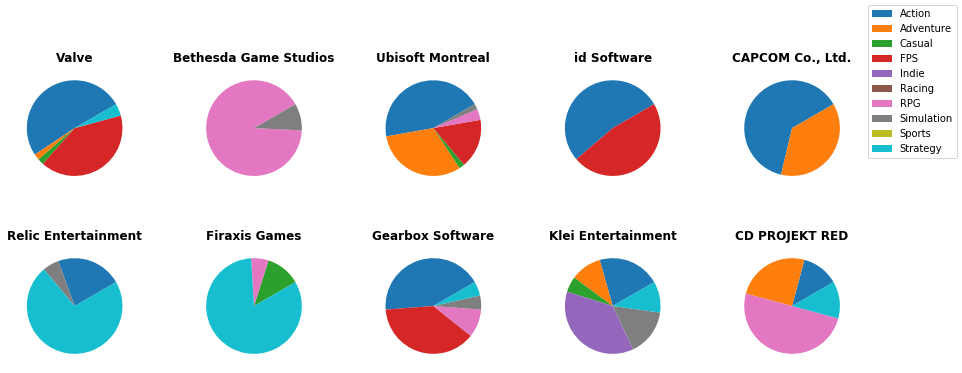

In [693]:
#plot pie charts of genres for top 10 dev
pi_chart_T=pi_chart_dev.transpose()
pi_chart_T.set_index(top_dev.index)
fig, axes = plt.subplots(2,5, figsize=(15,6)) #15,6
#color_list=['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
#label_list=['Action','Adventure','Casual','FPS','Indie','Racing','RPG','Simulation','Sports','Strategy']
color_map={'Action':'#1f77b4','Adventure':'#ff7f0e','Casual':'#2ca02c','FPS':'#d62728','Indie':'#9467bd','Racing':'#8c564b','RPG':'#e377c2','Simulation':'#7f7f7f','Sports':'#bcbd22','Strategy':'#17becf'}
for i, (idx, row) in enumerate(pi_chart_T.set_index(top_dev.index).iterrows()):
    ax = axes[i // 5, i % 5]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row,colors=[color_map[i] for i in row.index], startangle=30) #autopct='%1.1f%%',  labels=row.index,
    ax.set_title(idx, fontweight='bold')

fig.legend(handles=handle,labels=label,loc='upper right')
plt.subplots_adjust(wspace=0.5,right=0.9)

Most top developers focus on 1-2 genres. Most popular genres among top developers are Action, RPG, Strategy and Adventure.

### Radar chart on genres for developers/publishers

In [691]:
def radar_chart(df,col,comp,n):
    stats = df.iloc[:,-10:].sum() #df[df[col] == comp].iloc[:,-10:].sum()
    stats = stats[stats!=0]
    labels = np.array(list(stats.index))
    vals = stats.values
    vals = vals / sum(vals)+0.1
    print(vals)
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats=np.concatenate((vals,[vals[0]]))
    angles=np.concatenate((angles,[angles[0]]))
    print(angles)

    fig=plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', color='orange',linewidth=1)
    ax.fill(angles, stats, color='orange', alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels, fontsize=14)
    for label, angle in zip(ax.get_xticklabels(), angles):
        if 1.5*np.pi>angle>np.pi/2:
            label.set_horizontalalignment('right')
        else:
            label.set_horizontalalignment('left')
       
    ax.set_title(comp+' as '+col,fontweight='bold',fontsize=15,y=1.1)
    ax.set_rlim(0,n)
    ax.grid(True)
    ax.set_rgrids(np.arange(0,n,0.3), angle=45)
    

[0.36315789 0.15263158 0.78421053]
[0.        2.0943951 4.1887902 0.       ]


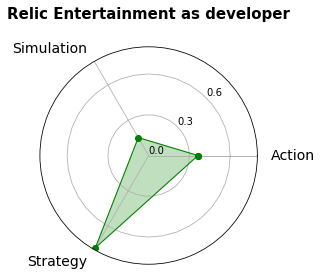

In [688]:
radar_chart(df[df['developer'].str.match("Relic")],'developer','Relic Entertainment',0.8)

[0.225 0.35  0.6   0.225]
[0.         1.57079633 3.14159265 4.71238898 0.        ]


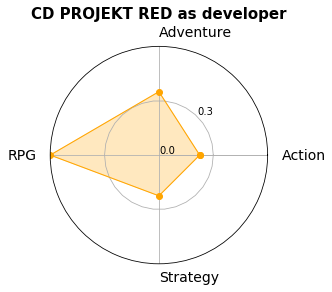

In [692]:
radar_chart(df[df['developer'].str.match("CD PROJEKT")],'developer','CD PROJEKT RED',0.6)

[0.6106383  0.1212766  0.52553191 0.14255319]
[0.         1.57079633 3.14159265 4.71238898 0.        ]


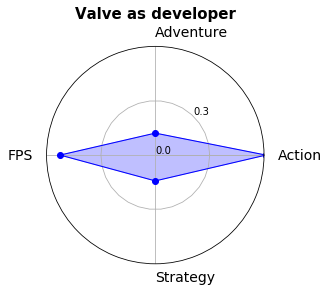

In [673]:
radar_chart(df[df['developer']=="Valve"],'developer','Valve',0.6)

[0.59056604 0.11886792 0.51509434 0.11886792 0.11886792 0.13773585]
[0.         1.04719755 2.0943951  3.14159265 4.1887902  5.23598776
 0.        ]


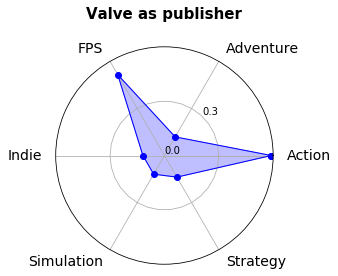

In [674]:
radar_chart(df[df['publisher'].str.match("Valve",case=False)],'publisher','Valve',0.6)

[0.55652174 0.42608696 0.12173913 0.25217391 0.14347826]
[0.         1.25663706 2.51327412 3.76991118 5.02654825 0.        ]


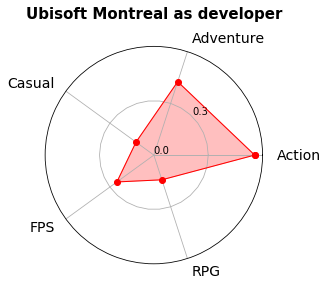

In [666]:
radar_chart(df[df['developer']=='Ubisoft Montreal'],'developer','Ubisoft Montreal',0.6)

[0.41944444 0.29907407 0.1462963  0.19259259 0.13240741 0.16481481
 0.1787037  0.16018519 0.12777778 0.1787037 ]
[0.         0.62831853 1.25663706 1.88495559 2.51327412 3.14159265
 3.76991118 4.39822972 5.02654825 5.65486678 0.        ]


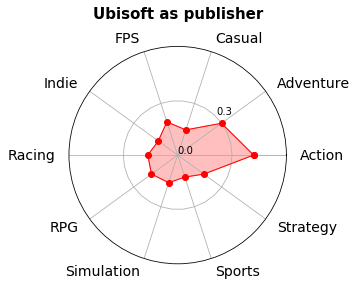

In [668]:
radar_chart(df[df['publisher'].str.match("Ubisoft")],'publisher','Ubisoft',0.6)

[0.38571429 0.17142857 0.17142857 0.24285714 0.52857143]
[0.         1.25663706 2.51327412 3.76991118 5.02654825 0.        ]


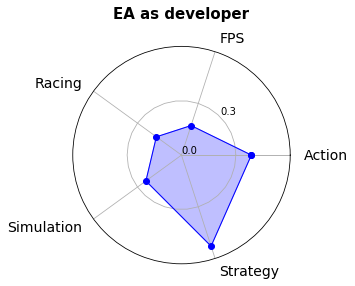

In [685]:
radar_chart(df[df['developer'].str.match("EA",case=True)],'developer','EA',0.6)

[0.4  0.14 0.22 0.16 0.2  0.24 0.2  0.24]
[0.         0.78539816 1.57079633 2.35619449 3.14159265 3.92699082
 4.71238898 5.49778714 0.        ]


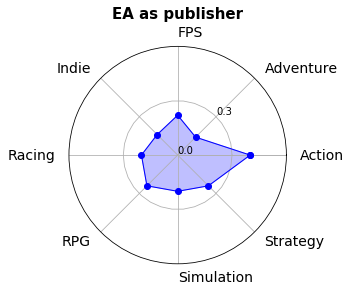

In [686]:
radar_chart(df[df['publisher'].str.match("Electronic Arts",case=True)],'publisher','EA',0.6)

[0.35925926 0.32222222 0.17407407 0.13703704 0.13703704 0.28518519
 0.13703704 0.13703704 0.21111111]
[0.         0.6981317  1.3962634  2.0943951  2.7925268  3.4906585
 4.1887902  4.88692191 5.58505361 0.        ]


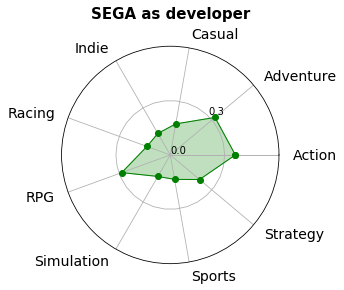

In [689]:
radar_chart(df[df['developer'].str.match("SEGA",case=False)],'developer','SEGA',0.6)

[0.37672956 0.22578616 0.13773585 0.10628931 0.21320755 0.13144654
 0.16918239 0.16289308 0.15031447 0.32641509]
[0.         0.62831853 1.25663706 1.88495559 2.51327412 3.14159265
 3.76991118 4.39822972 5.02654825 5.65486678 0.        ]


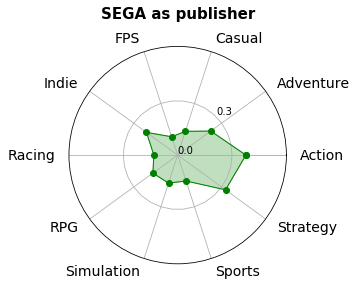

In [690]:
radar_chart(df[df['publisher'].str.match("SEGA",case=False)],'publisher','SEGA',0.6)

[0.30618557 0.15154639 0.14123711 0.18247423 0.13092784 0.18247423
 0.18247423 0.20309278 0.41958763]
[0.         0.6981317  1.3962634  2.0943951  2.7925268  3.4906585
 4.1887902  4.88692191 5.58505361 0.        ]


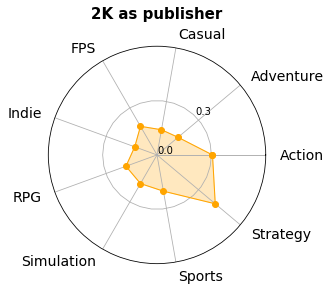

In [659]:
radar_chart(df[df['publisher'].str.match("2K",case=False)],'publisher','2K',0.6)

[1.00909091 0.19090909]
[0.         3.14159265 0.        ]


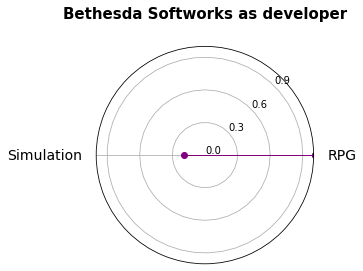

In [678]:
radar_chart(df[df['developer'].str.match("Bethesda")],'developer','Bethesda Softworks',1)

[0.51071429 0.17142857 0.33214286 0.35       0.11785714 0.11785714]
[0.         1.04719755 2.0943951  3.14159265 4.1887902  5.23598776
 0.        ]


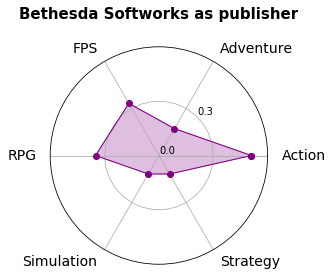

In [679]:
radar_chart(df[df['publisher'].str.match("Bethesda")],'publisher','Bethesda Softworks',0.6)

[0.30930233 0.14651163 0.16976744 0.75116279 0.12325581]
[0.         1.25663706 2.51327412 3.76991118 5.02654825 0.        ]


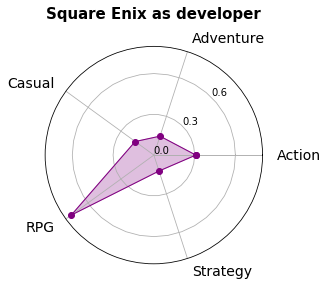

In [676]:
radar_chart(df[df['developer'].str.match("square enix",case=False)],'developer','Square Enix',0.8)

[0.48235294 0.31764706 0.13529412 0.12352941 0.13529412 0.10588235
 0.33529412 0.11176471 0.15294118]
[0.         0.6981317  1.3962634  2.0943951  2.7925268  3.4906585
 4.1887902  4.88692191 5.58505361 0.        ]


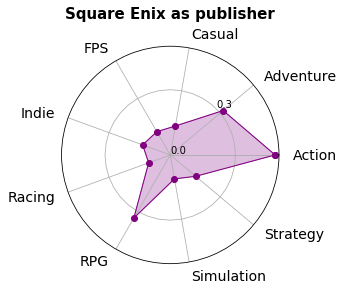

In [677]:
radar_chart(df[df['publisher'].str.match("square enix",case=False)],'publisher','Square Enix',0.5)

### Top 10 publishers

In [321]:
#pivot table for publisher
top_pub=pivot_col(df,'publisher')
top_pub

<class 'pandas.core.series.Series'>


,game_num,sum_owners,avg_price,avg_rating,avg_total_ratings,pub_score
publisher,,,,,,
Valve,30,510750000,6.692333,0.873341,197026.933333,0.800905
Ubisoft,112,81185000,20.097500,0.722535,10291.366071,0.687178
SEGA,91,78145000,21.308242,0.762820,5404.967033,0.684368
Devolver Digital,72,34800000,15.018194,0.804803,4833.986111,0.669310
Square Enix,106,72850000,17.377547,0.714637,6898.471698,0.667875
Bethesda Softworks,35,68035000,21.562571,0.781213,27799.314286,0.659883
2K,59,78030000,22.024068,0.681224,13007.050847,0.622788
Electronic Arts,33,43085000,18.626364,0.785201,6492.848485,0.617256
Paradox Interactive,56,41615000,17.936607,0.708894,7270.910714,0.607100


In [322]:
top_game_pub=top_game_of_company(df,top_pub,'publisher')
top_game_pub

,pub_score,top_5_game
publisher,,
Valve,0.800905,"Portal 2, Portal, Counter-Strike, Left 4 Dead 2, Half-Life 2"
Ubisoft,0.687178,"South Park™: The Stick of Truth™, Valiant Hearts: The Great War™ / Soldats Inconnus : Mémoires de la Grande Guerre™, Child of Light, Dark Messiah of Might & Magic, Trackmania United Forever Star Edition"
SEGA,0.684368,"Total War: MEDIEVAL II – Definitive Edition, Warhammer® 40,000: Dawn of War® - Dark Crusade, Warhammer® 40,000: Dawn of War® - Soulstorm, Warhammer® 40,000: Dawn of War® - Game of the Year Edition, Alien: Isolation"
Devolver Digital,0.669310,"Hotline Miami, The Expendabros, Broforce, The Talos Principle, Downwell"
Square Enix,0.667875,"Life is Strange - Episode 1, Tomb Raider, Supreme Commander: Forged Alliance, Deus Ex: Game of the Year Edition, Life is Strange: Before the Storm"
Bethesda Softworks,0.659883,"Dishonored, Fallout: New Vegas, The Elder Scrolls V: Skyrim, The Elder Scrolls IV: Oblivion® Game of the Year Edition, The Elder Scrolls III: Morrowind® Game of the Year Edition"
2K,0.622788,"Sid Meier's Civilization® V, BioShock Infinite, XCOM: Enemy Unknown, Mafia II, Borderlands 2"
Electronic Arts,0.617256,"Mass Effect 2, Dead Space™ 2, Mass Effect, Dragon Age: Origins, Dragon Age: Origins - Ultimate Edition"
Paradox Interactive,0.607100,"Prison Architect, Cities: Skylines, Magicka, Knights of Honor, Crusader Kings II"


In [323]:
pi_chart_pub=genre_and_company(df, top_pub, 'publisher')
pi_chart_pub

,Valve,Ubisoft,SEGA,Devolver Digital,Square Enix,Bethesda Softworks,2K,Electronic Arts,Paradox Interactive,Warner Bros. Interactive Entertainment
Action,26,69,44,50,65,20,20,15,6,26
Adventure,1,43,20,30,37,4,5,2,8,22
Casual,0,10,6,11,6,0,4,0,1,3
FPS,22,20,1,9,4,10,8,6,0,3
Indie,1,7,18,68,6,0,3,3,9,0
Racing,0,14,5,1,1,0,0,5,0,0
RPG,0,17,11,5,40,14,8,7,18,0
Simulation,1,13,10,9,2,1,8,5,17,0
Sports,0,6,8,3,0,0,10,0,0,0
Strategy,2,17,36,7,9,1,31,7,46,2


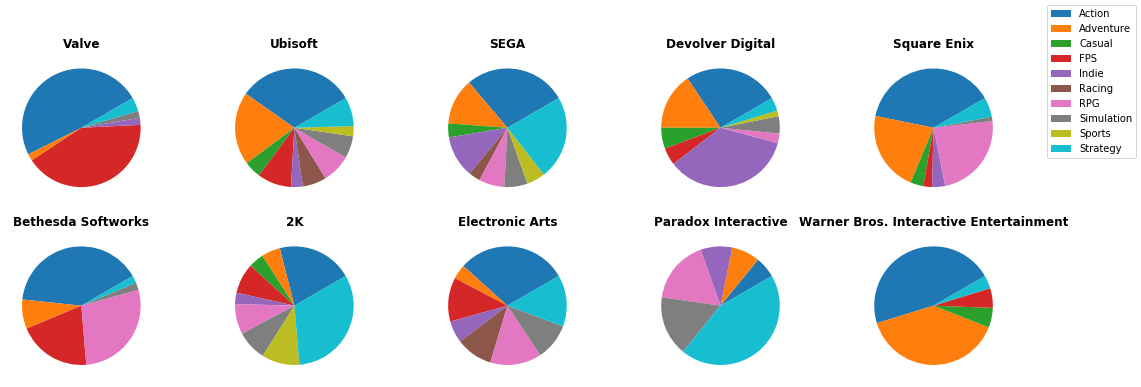

In [340]:
pi_chart_pub_T=pi_chart_pub.transpose()
pi_chart_pub_T.set_index(top_pub.index)
color_dict={}
#plot pie charts of genres for top 10 publisher
fig, axes = plt.subplots(2, 5, figsize=(18, 6))
color_map={'Action':'#1f77b4','Adventure':'#ff7f0e','Casual':'#2ca02c','FPS':'#d62728','Indie':'#9467bd','Racing':'#8c564b','RPG':'#e377c2','Simulation':'#7f7f7f','Sports':'#bcbd22','Strategy':'#17becf'}
for i, (idx, row) in enumerate(pi_chart_pub_T.set_index(top_pub.index).iterrows()):
    ax = axes[i // 5, i % 5]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row, colors=[color_map[i] for i in row.index], startangle=30) #autopct='%1.1f%%',labels=row.index,
    ax.set_title(idx, fontweight='bold')
fig.legend(handles=handle,labels=label)
plt.subplots_adjust(wspace=0.4,right=0.9)

Compared to the pie charts of top developers, top publishers show more variety in game genres published. Still, Action, Adventure, Strategy games are among the most popular genres.

### Top publishers stacked bar chart over time

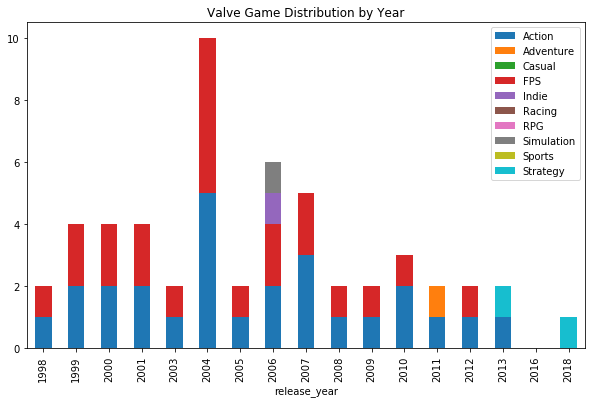

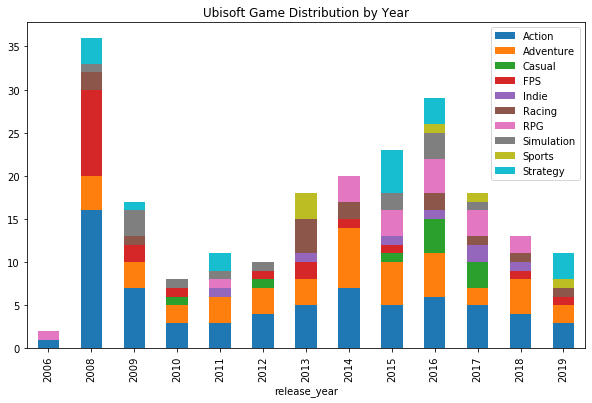

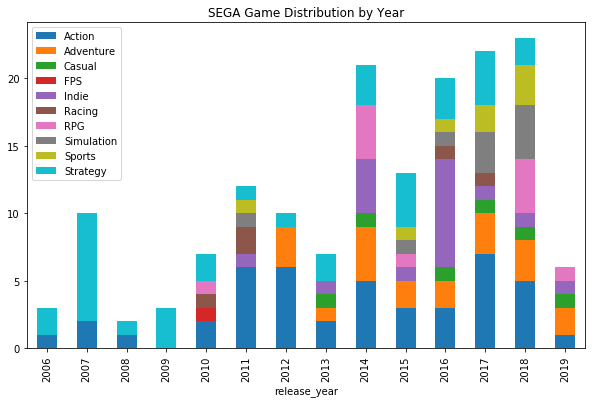

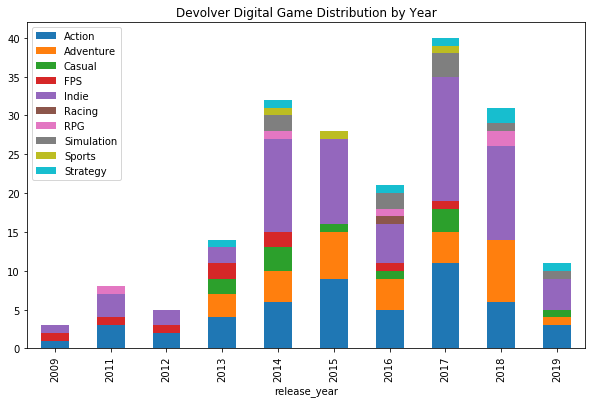

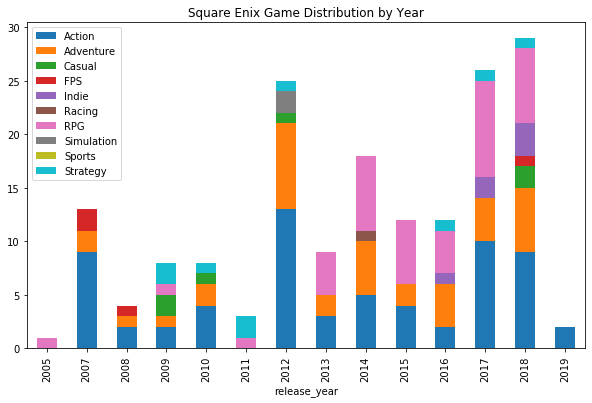

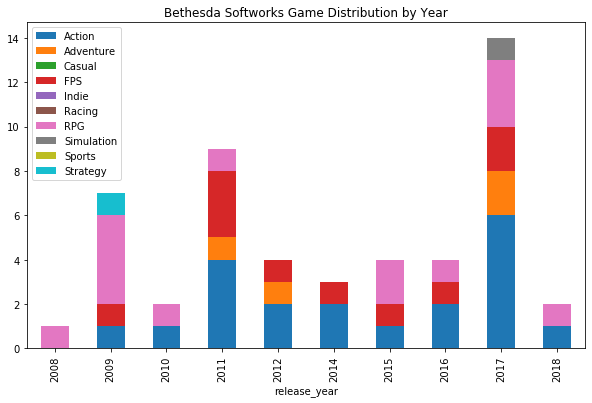

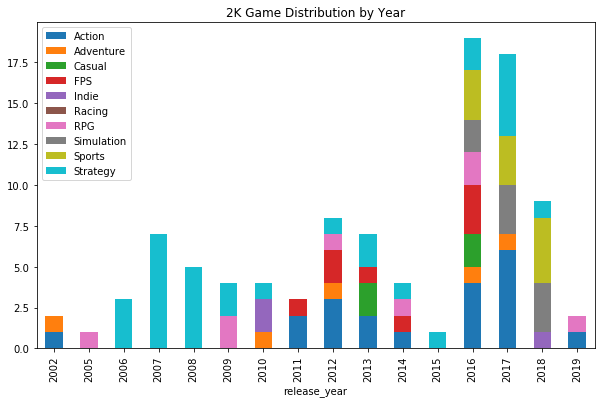

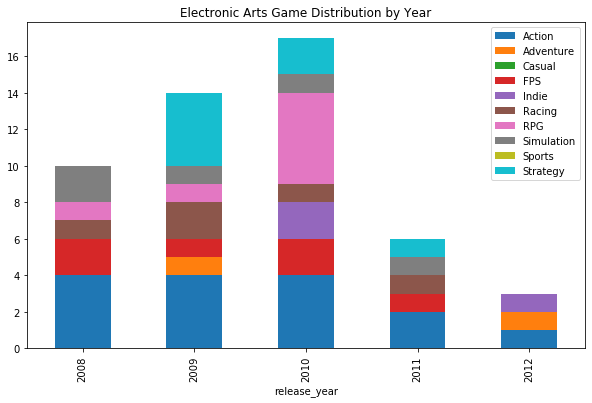

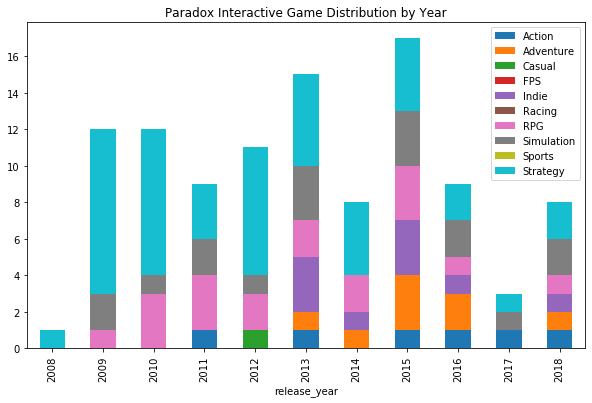

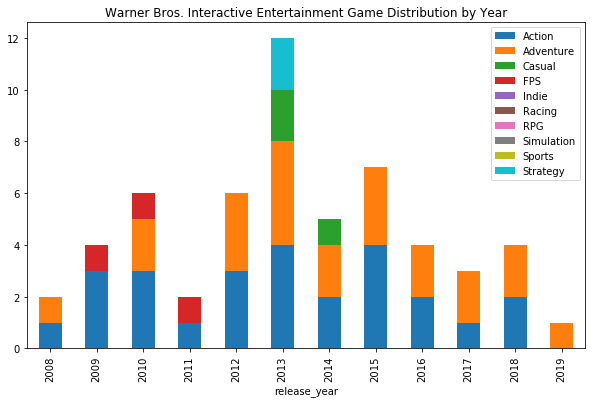

In [681]:
for pub in top_pub.index:
    pub_df=df[df['publisher'].str.match(pub,case=False)].groupby('release_year').sum()
    ax=pub_df.loc[:,['Action','Adventure','Casual','FPS','Indie','Racing','RPG','Simulation','Sports','Strategy']]
    ax.plot.bar(stacked=True,figsize=(10,6), title=pub+" Game Distribution by Year")
ax = plt.gca()
handle,label=ax.get_legend_handles_labels()